In [1]:
## import python modules
import numpy as np
import xarray as xr
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import glob
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
import datetime as dt

#from matplotlib import animation
from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# import matplotlib.animation as animation

# from matplotlib import rc
import matplotlib
#plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
%matplotlib inline
from PIL import Image, ImageDraw
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import matplotlib.image as mgimg
from collections import Counter
from global_land_mask import globe
import scipy.optimize as opt

We will use precipitation and column relative humidity to characterize the environment of tropical cyclones as identified by the TempestExtremes Algorithm. The data is spaced 6 hours apart with a horizontal resolution of $\sim$ 0.25 deg. 

In [2]:
# set paths to read crh and precipitation data

In [3]:
buoy_path ='/neelin2020/ERA-5_buoy/layer_thetae/era5_2layers_thetae_'
precip_path='/neelin2020/TRMM_3B42/TRMM.3hrly.3B42.'
#buoy_path ='/neelin2020/ERA-5_buoy/layer_thetae/'
#buoy_print='/neelin2020/ERA-5_buoy/layer_thetae/2002_01_01.nc'
#print(buoy_print)
number = []
offset = []
non_landfall = []
tropics = []


class hurricane reads year and extracts number of TCs, and related thermodynamic and precipitation fields from ERA5 data

In [4]:
number = []
offset = []
non_landfall = []
landfall = []
tropics = []
class hurricance:
    
    def __init__(self,year,paths):
        self.year=year
        self.buoy_path=paths[0]
        self.precip_path=paths[1]
        #self.buoy_path=paths[2]
        self.offset=5 ## box size in deg. lat/lon around feature center
        offset.append(self.offset)
    def __extract_dates(self,date_array):
        dates=[]
        for n in range(date_array.shape[0]):
            yr,mo,dy,hr=np.int_(date_array[n])
            dates.append(dt.datetime(yr,mo,dy,hr))
        
        return dates    
    
    def extract_tracks(self):
        
        ### read Tempest Extremes Tracks for ERA-5
        fili='/neelin2020/TempestExtremes/TC/ERA5_TC_tracks_20200824.txt'
        
        f=open(fili,'r')
        lines = f.readlines()    # Read file and close
        f.close()

        i=0
        self.tc_tracks={}
        ctr=0

        while (i < (len(lines)-1) ):
            line = lines[i]
            i = i+1
            linesplit = line.strip().split('\t')
            if linesplit[0] == 'start' :
                tracklength = int(linesplit[1])
                trackarray = np.genfromtxt(lines[i:(i+tracklength)])
                dates=self.__extract_dates(np.int_(trackarray[:,-4:]))
                lon=trackarray[:,2]
                lat=trackarray[:,3]
                psl=trackarray[:,4]*1e-2 ### in hPa
                max_wind=trackarray[:,5]
                
        #         if(np.logical_and(dates[0].year>start_year, dates[-1].year<=end_year)): ## for start and end years
                if(dates[0].year==self.year & dates[-1].year==self.year):
                    self.tc_tracks[ctr]={}
                    self.tc_tracks[ctr]['lat']=lat
                    self.tc_tracks[ctr]['lon']=lon
                    self.tc_tracks[ctr]['dates']=dates
                    self.tc_tracks[ctr]['psl']=psl
                    self.tc_tracks[ctr]['maxwind']=max_wind
                    ctr+=1
        print('There are {:d} Tropical Cyclones in {:d}'.format(ctr,self.year))
        number.append(ctr)
    def read_data(self):
        
        '''
        This is the function that reads the buoyancy 
        fields from the ERA5 product.
        '''

        self.ds_comp={}
        
        for key in self.tc_tracks.keys():

            fil_era5=glob.glob(self.buoy_path+'2002_01_01.nc')[0]
            ds_buoy=xr.open_dataset(fil_era5)
            ds_buoy.close()
            
            dates=self.tc_tracks[key]['dates']
            
            nan_array=np.zeros((len(dates),ds_buoy.lat.size,ds_buoy.lon.size))
            nan_array[:]=np.nan    
                

            self.ds_comp[key] = xr.Dataset(
                data_vars=dict(
                    #crh=(["time","lat", "lon"], nan_array.copy()),
                    CAPE =(["time","lat", "lon"], nan_array.copy()),
                    Subsaturation=(["time","lat", "lon"], nan_array.copy()),
                    Buoyancy=(["time","lat", "lon"], nan_array.copy()),
                    EQBL=(["time","lat", "lon"], nan_array.copy()),
                    EQSLFT=(["time","lat", "lon"], nan_array.copy()),
                    EQULFT=(["time","lat", "lon"], nan_array.copy()),
                    precipitation=(["time","lat", "lon"], nan_array.copy()),
                ),
                coords=dict(
                    lon=(ds_buoy.lon),
                    lat=(ds_buoy.lat),
                    time=dates,
                ))
                
    #print(self.buoy_path+'2002_01_01.nc')     
                                    
            for i,j,k in zip(self.tc_tracks[key]['lat'],self.tc_tracks[key]['lon'],self.tc_tracks[key]['dates']):
                try:
                    fil_era5=glob.glob(self.buoy_path+dt.datetime.strftime(k,'%Y_%m_%d')+'.nc')[0]
                    fil_precip=glob.glob(self.precip_path+dt.datetime.strftime(k,'%Y%m*')+'.nc')[0]
                except:
                    print('Files not found')
                    break
                

                ### extract lat, lon ranges for each date ###
                ds_buoy=xr.open_dataset(fil_era5)
                ds_precip=xr.open_dataset(fil_precip)
                ds_precip=ds_precip.rename({'latitude':'lat',
                                           'longitude':'lon'})
                
                la=ds_buoy.lat
                lc=ds_buoy.lon

                loc_dict=dict(lat=la[(la>=i-self.offset) & (la<=i+self.offset)],
                       lon=lc[(lc>=j-self.offset) & (lc<=j+self.offset)])

                loc_dict_time=dict(time=k,
                                   lat=la[(la>=i-self.offset) & (la<=i+self.offset)],
                       lon=lc[(lc>=j-self.offset) & (lc<=j+self.offset)])

                
                if len(loc_dict['lat'])==0:
                    print('Latitude out of bounds')
                    break

                thetae_bl=ds_buoy.thetae_bl.sel(time=k,method='nearest').loc[loc_dict]
                #print(thetae_bl)
                thetae_lt=ds_buoy.thetae_lt.sel(time=k,method='nearest').loc[loc_dict]
                thetae_sat_lt=ds_buoy.thetae_sat_lt.sel(time=k,method='nearest').loc[loc_dict]
                #print(thetae_sat_lt)
#                 print([loc_dict])
                CAPE_new = ((thetae_bl-thetae_sat_lt)/thetae_sat_lt)*340
                SUBSAT_new = ((thetae_sat_lt-thetae_lt)/thetae_sat_lt)*340
                BUOY_new = (9.8/(340*3))*((.5*CAPE_new)-(.5*SUBSAT_new))
                #crh_inst=cwv/cwv_sat
                self.ds_comp[key]['CAPE'].loc[loc_dict_time]=CAPE_new
                
                self.ds_comp[key]['Subsaturation'].loc[loc_dict_time]=SUBSAT_new
                
                self.ds_comp[key]['Buoyancy'].loc[loc_dict_time]=BUOY_new
                
                self.ds_comp[key]['EQBL'].loc[loc_dict_time]=thetae_bl
                self.ds_comp[key]['EQSLFT'].loc[loc_dict_time]=thetae_sat_lt
                self.ds_comp[key]['EQULFT'].loc[loc_dict_time]=thetae_lt
                prc_inst=ds_precip.precip_trmm.sel(time=k,method='nearest').loc[loc_dict]
                self.ds_comp[key]['precipitation'].loc[loc_dict_time]=prc_inst
                

                
                ds_buoy.close()
                ds_precip.close()
            
            self.ds_comp[key].close()
            print(key, 'Max wind: {:.2f} m/s, Min psl: {:.2f} hPa'.format(max(self.tc_tracks[key]['maxwind']), min(self.tc_tracks[key]['psl'])))
            print(tcs.ds_comp[key].time.dt.strftime("%Y%m%d-%H").isel(time=0).item())
            long_array=tcs.tc_tracks[key]['lon'] #taking latitude and longitude arrays
            lati_array=tcs.tc_tracks[key]['lat']
            breaker = 0
            breakers = 0
            for lan in range(len(long_array)):
                if long_array[lan] >= 180: #since the landmask array takes negatives instead of 360
                    long_array[lan] = long_array[lan]-360
                if globe.is_land(lati_array[lan], long_array[lan]) == True: #if one value is on the landmask
                    
                    if breaker == 0:
                        breaker = breaker+1 #so it doesn't print landfall for every point
                        print("Landfalls at some point")
                        landfall.append(key) #append to landfall list
                if globe.is_land(lati_array[lan], long_array[lan]) == False: #for storms that never hit the landmask
                    breakers = breakers + 1
                if long_array[lan] < 0:
                    long_array[lan] = long_array[lan]+360
                if breakers == len(lati_array): #if every position is not over land
                    non_landfall.append(key)#append to nonlandfall list
            passer = 0 
            for lin in range(len(lati_array)):
                if (lati_array[lin] >= (-35+offset[0])) and (lati_array[lin] <= (35-offset[0])):
                    passer = passer + 1
                    #if the box around a storm passes 35 degree latitude or not
                if passer == len(lati_array): #if all positions are within the tropics
                    print("Stays in the Tropics")
                    tropics.append(key)
            #so I know what basin a storm belongs to (isn't perfect)
            if long_array[0] >= 261 and long_array[0] <= 359:
                print("Atlantic")
            elif long_array[0] >= 220 and long_array[0] < 261 and lati_array[0] >= 0:
                print("East Pacific")
            elif long_array[0] >= 180 and long_array[0] < 220 and lati_array[0] >= 0:
                print("Central Pacific")
            elif long_array[0] >= 100 and long_array[0] < 180 and lati_array[0] >= 0:
                print("West Pacific")
            elif long_array[0] >= 45 and long_array[0] < 100 and lati_array[0] >= 0:
                print("North Indian")
            elif long_array[0] >= 20  and long_array[0] < 90 and lati_array[0] < 0:
                print("Southwest Indian")
            elif long_array[0] >= 90  and long_array[0] < 160 and lati_array[0] < 0:
                print("Australian")
            elif long_array[0] >= 160  and long_array[0] < 300 and lati_array[0] < 0:
                print("South Pacific")
            else:
                print("That's not right!")
            print("\n")

In [5]:
%%time
### read 
year=2013 ## enter year here. We have years 2002-2014 processed
tcs=hurricance(year,[buoy_path,precip_path])
tcs.extract_tracks()  
tcs.read_data()
internal = 1 #determine the size of an inner box compared to its environment
#Updates to Include: Find an equation via machine learning to auto calculate the storm's size

There are 77 Tropical Cyclones in 2013
0 Max wind: 21.37 m/s, Min psl: 994.40 hPa
20130103-00
Stays in the Tropics
West Pacific


1 Max wind: 28.77 m/s, Min psl: 960.86 hPa
20130106-06
Stays in the Tropics
Australian


2 Max wind: 18.00 m/s, Min psl: 999.58 hPa
20130111-00
Stays in the Tropics
Southwest Indian


Latitude out of bounds
3 Max wind: 28.17 m/s, Min psl: 935.96 hPa
20130115-18
Landfalls at some point
West Pacific


4 Max wind: 17.23 m/s, Min psl: 997.26 hPa
20130116-06
Landfalls at some point
Stays in the Tropics
Southwest Indian


5 Max wind: 22.71 m/s, Min psl: 986.93 hPa
20130118-18
South Pacific


Latitude out of bounds
6 Max wind: 31.73 m/s, Min psl: 963.42 hPa
20130124-18
Southwest Indian


7 Max wind: 15.93 m/s, Min psl: 1003.59 hPa
20130208-00
Stays in the Tropics
South Pacific


8 Max wind: 29.47 m/s, Min psl: 963.46 hPa
20130209-12
Stays in the Tropics
Southwest Indian


9 Max wind: 22.97 m/s, Min psl: 992.88 hPa
20130209-18
South Pacific


10 Max wind: 29.01 m/s,

In [6]:
off_check = offset[0]-internal #offset is the box size, internal is the inner box
off_range = (2*offset[0])-.25 #for the size of the inner box

tropic_non_landfall = []

for i in range(len(tropics)):
    for j in range(len(non_landfall)):
        if tropics[i] == non_landfall[j]:
            #so I can coordinate storms that stay within the tropics and don't landfall
            tropic_non_landfall.append(tropics[i])
#print(tropic_non_landfall)

tropic_landfall = []
for i in range(len(tropics)):
    for j in range(len(landfall)):
        if tropics[i] == landfall[j]:
            tropic_landfall.append(tropics[i])
            
print(landfall)
print(non_landfall)
tc_number = 66 #choice of tropical cyclone for the graphs below to evaluate them solo

[3, 4, 10, 12, 22, 25, 29, 32, 36, 37, 40, 47, 48, 49, 51, 53, 54, 56, 58, 64, 65, 66, 67]
[0, 1, 2, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 30, 31, 33, 34, 35, 38, 39, 41, 42, 43, 44, 45, 46, 50, 52, 55, 57, 59, 60, 61, 62, 63, 68, 69, 70, 71, 72, 73, 74, 75, 76]


# Calculates the Average Across the Entire Offset Box

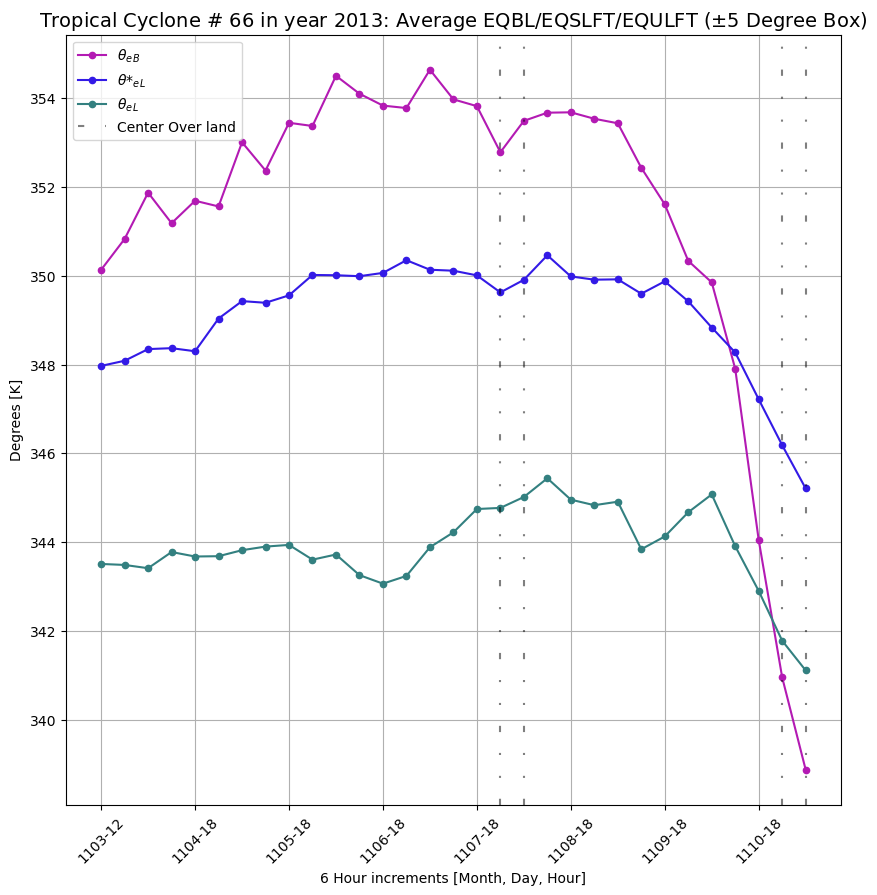

In [17]:

g = np.int_(np.linspace(0,tcs.ds_comp[tc_number].precipitation.time.size-1)) #so I get the exact number of frames
x = np.arange(0,max(g)+1,1)
eqblwhole = [0] * len(x) #empty array for EQBL
eqslftwhole= [0] * len(x) #empty array for EQSLFT
equlftwhole = [0] * len(x) #empty array for EQULFT
subswhole = [0] * len(x) #empty array for subsaturation
capewhole = [0] * len(x) #empty array for CAPE
buoywhole = [0] * len(x) #empty array for buoyancy
preciwhole = [0] * len(x) #empty array for precipitation 
off_check = offset[0]-internal
off_range = (2*offset[0])-.25 #size of box, minus .25 since the box is smaller by .25
box_size = [] 
lat_array=tcs.tc_tracks[tc_number]['lat']
lon_array=tcs.tc_tracks[tc_number]['lon']
for t in range(max(g)+1):
    #print(t)

    eqbl= tcs.ds_comp[tc_number].EQBL.isel(time=t)
    eqslft= tcs.ds_comp[tc_number].EQSLFT.isel(time=t)
    equlft= tcs.ds_comp[tc_number].EQULFT.isel(time=t)
    subs= tcs.ds_comp[tc_number].Subsaturation.isel(time=t)
    cape= tcs.ds_comp[tc_number].CAPE.isel(time=t)
    buoy= tcs.ds_comp[tc_number].Buoyancy.isel(time=t)
    preci= tcs.ds_comp[tc_number].precipitation.isel(time=t)
    
    eqblada=eqbl.stack(x=['lon','lat'])
    eqbla=eqblada[eqblada.notnull()] #so I can manipulate the values for this factor and take the inside and outside
    if len(eqbla.lon.values) == 0:
        eqblwhole[t]=(float("nan")) #for storms that have no values to calculate (above/below 35 N/S)
        eqslftwhole[t]=(float("nan"))
        equlftwhole[t]=(float("nan"))
        subswhole[t]=(float("nan"))
        capewhole[t]=(float("nan"))
        buoywhole[t]=(float("nan"))
        preciwhole[t]=(float("nan"))
        box_size.append(t)
    else:
        eqblaorder=eqbla.sortby(eqbla.lat) #since latitude values are out of order
        rr=max(eqblaorder.lat.values)
        oo=min(eqblaorder.lat.values)
        if rr-oo == off_range:
            box_size.append("x")
        else:
            box_size.append(t)
        eqblwhole[t] = np.nanmean(eqbl)
        eqslftwhole[t] = np.nanmean(eqslft)
        equlftwhole[t] = np.nanmean(equlft)
        subswhole[t] = np.nanmean(subs)
        capewhole[t] = np.nanmean(cape)
        buoywhole[t] = np.nanmean(buoy)
        preciwhole[t] = np.nanmean(preci)

time_array = []
for t in range(max(g)+1):
    v = tcs.ds_comp[tc_number].time.dt.strftime("%m%d-%H").isel(time=t).item()
    time_array.append(v)
plt.figure(figsize = (10,10))
plt.xticks(x, time_array, rotation = 45)
plt.locator_params(axis='x', nbins=len(x)/4)
plt.plot(x,eqblwhole, color=[.7,.1,.7], marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$")
plt.plot(x,eqslftwhole, color=[.2,.1,.9], marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$")
plt.plot(x,equlftwhole, color=[.2,.5,.5], marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$")
tes = []
te = []
for na in eqblwhole:
    if np.isnan(na):
        te.append(na)
    else:
        tes.append(na)
if len(te) != 0:
    leng = len(tes)
    plt.axvline(x=x[leng-1], linestyle ="--", color="k", label = "Storm Passes 35{} N/S, Persists {} More Hours".format(chr(176), 6*len(te)))
breaks = 0 #so the label doesn't repeat
for lin in range(len(eqblwhole)): #so I can show what times a storm box is not full size

    if (type(box_size[lin]) == int) & (breaks != 0): #so the label doesn't repeat
        
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B")
    if (type(box_size[lin]) == int) & (breaks == 0):
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B", label = "Box is Not Full Size")
        breaks = breaks + 1
        
breaker = 0 #so the label doesn't repeat
for lan in range(len(eqblwhole)): #so I can show what time values have a storm on land
    if lon_array[lan] >= 180: #to correct the landmask
        lon_array[lan] = lon_array[lan]-360
    if globe.is_land(lat_array[lan], lon_array[lan]) == True:
        if breaker != 0: #so the label doesn't repeat
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5)
        if breaker == 0:
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5, label = "Center Over land")
            breaker = breaker + 1


plt.grid()
plt.legend()
plt.xlabel("6 Hour increments [Month, Day, Hour]", fontsize = 10)

plt.ylabel("Degrees [K]", fontsize = 10)

plt.title('Tropical Cyclone # {:d} in year {:d}: Average EQBL/EQSLFT/EQULFT ($\u00B1${} Degree Box)'.format(tc_number,year,offset[0]),fontsize=14);

# Calculates the Average of the Internal Values (Determined by Internal Box Size)

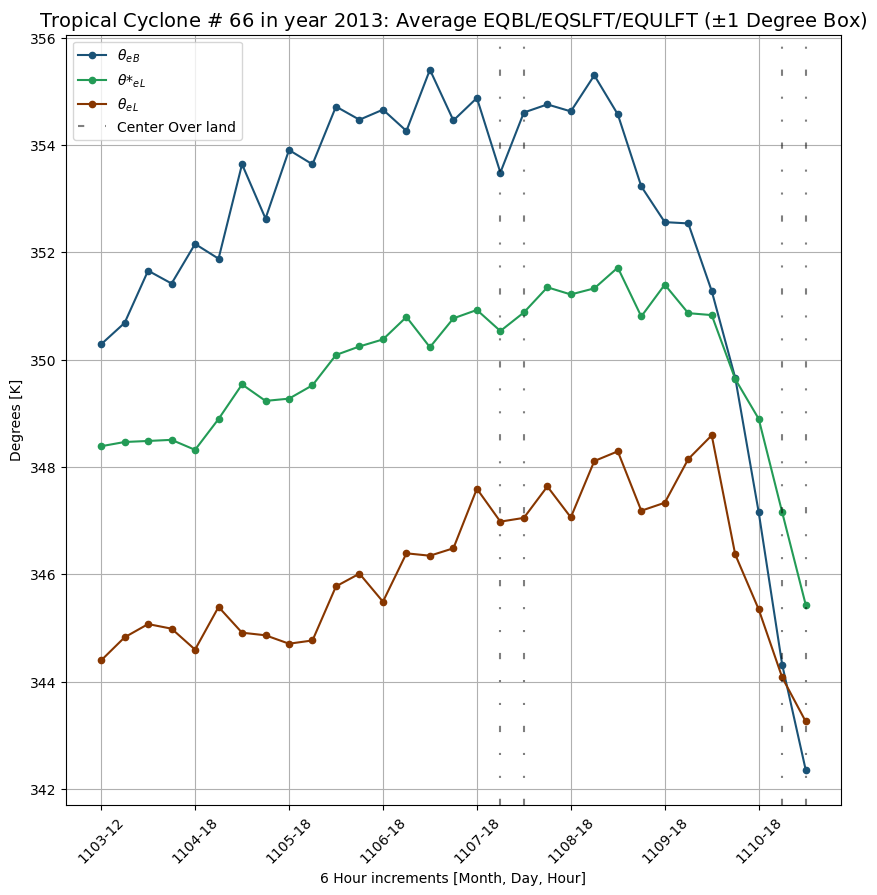

In [21]:
off_check = offset[0]-internal
off_range = (2*offset[0])-.25
lat_array=tcs.tc_tracks[tc_number]['lat']
lon_array=tcs.tc_tracks[tc_number]['lon']
g = np.int_(np.linspace(0,tcs.ds_comp[tc_number].precipitation.time.size-1)) #so I get the exact number of frames
x = np.arange(0,max(g)+1,1)
eqblint = [0] * len(x) #empty array for EQBL
eqslftint= [0] * len(x) #empty array for EQSLFT
equlftint = [0] * len(x) #empty array for EQULFT
subsint = [0] * len(x) #empty array for subsaturation
capeint = [0] * len(x) #empty array for CAPE
buoyint = [0] * len(x) #empty array for buoyancy
preciint = [0] * len(x) #empty array for precipitation 
box_size = []


for t in range(max(g)+1):
        
    
    eqbl= tcs.ds_comp[tc_number].EQBL.isel(time=t) #taking the values for equivalent pot. temp. in the ABL
    eqblada=eqbl.stack(x=['lon','lat'])
    eqbla=eqblada[eqblada.notnull()] #so I can manipulate the values for this factor and take the inside and outside

    eqslft= tcs.ds_comp[tc_number].EQSLFT.isel(time=t) #taking the values for equivalent sat. pot. temp. in the LFT
    eqslftada=eqslft.stack(x=['lat','lon'])
    eqslfta=eqslftada[eqslftada.notnull()]

    equlft= tcs.ds_comp[tc_number].EQULFT.isel(time=t) #taking the values for equivalent unsat. pot. temp. in the LFT
    equlftada=equlft.stack(x=['lat','lon'])
    equlfta=equlftada[equlftada.notnull()]

    subs= tcs.ds_comp[tc_number].Subsaturation.isel(time=t) #taking the values for subsaturation in the LFT
    subsada_stacked=subs.stack(x=['lat','lon'])
    subsa=subsada_stacked[subsada_stacked.notnull()]

    cape= tcs.ds_comp[tc_number].CAPE.isel(time=t) #taking the values for CAPE in the LFT
    capada_stacked=cape.stack(x=['lat','lon'])
    capea=capada_stacked[capada_stacked.notnull()]

    buoy= tcs.ds_comp[tc_number].Buoyancy.isel(time=t) #taking the buoyancy for buoyancy in the LFT
    buoyada=buoy.stack(x=['lat','lon'])
    buoya=buoyada[buoyada.notnull()]

    preci= tcs.ds_comp[tc_number].precipitation.isel(time=t) #taking the values for precipitation
    preciada=preci.stack(x=['lat','lon'])
    precia=preciada[preciada.notnull()]
    if len(eqblada.lon.values) == 0:
        
        eqblint[t]=(float("nan")) #for storms that have no values to calculate (above/below 35 N/S)
        eqslftint[t]=(float("nan"))
        equlftint[t]=(float("nan"))
        subsint[t]=(float("nan"))
        capeint[t]=(float("nan"))
        buoyint[t]=(float("nan"))
        preciint[t]=(float("nan"))
        box_size.append(t)
    else:
        r=max(eqblada.lon.values)
        o=min(eqblada.lon.values)
        pp=o+off_check
        qq=r-off_check
        
        eqblaorder=eqbla.sortby(eqbla.lat)
        rr=max(eqblaorder.lat.values)
        oo=min(eqblaorder.lat.values)
        if rr-oo == off_range: #for the box when full sized
            p=oo+off_check
            q=rr-off_check
            eqbl_check = eqbla.where((eqbla.lon>=pp) & (eqbla.lon<=qq) & (eqbla.lat>=p) & (eqbla.lat<=q))
            eqslft_check = eqslfta.where((eqslfta.lon>=pp) & (eqslfta.lon<=qq) & (eqslfta.lat>=p) & (eqslfta.lat<=q))
            equlft_check = equlfta.where((equlfta.lon>=pp) & (equlfta.lon<=qq) & (equlfta.lat>=p) & (equlfta.lat<=q))
            
            subs_check = subsa.where((subsa.lon>=pp) & (subsa.lon<=qq) & (subsa.lat>=p) & (subsa.lat<=q))
            cape_check = capea.where((capea.lon>=pp) & (capea.lon<=qq) & (capea.lat>=p) & (capea.lat<=q))
            
            buoy_check = buoya.where((buoya.lon>=pp) & (buoya.lon<=qq) & (buoya.lat>=p) & (buoya.lat<=q))
            preci_check = precia.where((precia.lon>=pp) & (precia.lon<=qq) & (precia.lat>=p) & (precia.lat<=q))

            box_size.append("x")
        elif (rr-oo < off_range) & (rr-oo >= (off_check+2.5)) & (lat_array[0] > 0): 
            #for when the box's northern end is less than complete, and cuts part of the top
            p=oo+off_check
            offer = off_range-(rr-oo)
            off_fix=off_check-offer
            q=rr-off_fix
            eqbl_check = eqbla.where((eqbla.lon>=pp) & (eqbla.lon<=qq) & (eqbla.lat>=p) & (eqbla.lat<=q))
            eqslft_check = eqslfta.where((eqslfta.lon>=pp) & (eqslfta.lon<=qq) & (eqslfta.lat>=p) & (eqslfta.lat<=q))
            equlft_check = equlfta.where((equlfta.lon>=pp) & (equlfta.lon<=qq) & (equlfta.lat>=p) & (equlfta.lat<=q))
            
            subs_check = subsa.where((subsa.lon>=pp) & (subsa.lon<=qq) & (subsa.lat>=p) & (subsa.lat<=q))
            cape_check = capea.where((capea.lon>=pp) & (capea.lon<=qq) & (capea.lat>=p) & (capea.lat<=q))
            
            buoy_check = buoya.where((buoya.lon>=pp) & (buoya.lon<=qq) & (buoya.lat>=p) & (buoya.lat<=q))
            preci_check = precia.where((precia.lon>=pp) & (precia.lon<=qq) & (precia.lat>=p) & (precia.lat<=q))
            box_size.append(t)
        elif (rr-oo > off_check) & (rr-oo < (off_check+2.5)) & (lat_array[0] > 0):
            #for when the box's northern end is less than complete, and cuts into the internal part of the box
            p=oo+off_check
            q=rr
            eqbl_check = eqbla.where((eqbla.lon>=pp) & (eqbla.lon<=qq) & (eqbla.lat>=p) & (eqbla.lat<=q))
            eqslft_check = eqslfta.where((eqslfta.lon>=pp) & (eqslfta.lon<=qq) & (eqslfta.lat>=p) & (eqslfta.lat<=q))
            equlft_check = equlfta.where((equlfta.lon>=pp) & (equlfta.lon<=qq) & (equlfta.lat>=p) & (equlfta.lat<=q))
            
            subs_check = subsa.where((subsa.lon>=pp) & (subsa.lon<=qq) & (subsa.lat>=p) & (subsa.lat<=q))
            cape_check = capea.where((capea.lon>=pp) & (capea.lon<=qq) & (capea.lat>=p) & (capea.lat<=q))
            
            buoy_check = buoya.where((buoya.lon>=pp) & (buoya.lon<=qq) & (buoya.lat>=p) & (buoya.lat<=q))
            preci_check = precia.where((precia.lon>=pp) & (precia.lon<=qq) & (precia.lat>=p) & (precia.lat<=q))
            box_size.append(t)
        elif (rr-oo < off_range) & (rr-oo >= (off_check+2.5)) & (lat_array[0] < 0):
            #for when the box's southern end is less than complete, and cuts part of the bottom
            offer = off_range-(rr-oo)
            off_fix=off_check-offer
            p=oo+off_fix
            q=rr-off_check
            eqbl_check = eqbla.where((eqbla.lon>=pp) & (eqbla.lon<=qq) & (eqbla.lat>=p) & (eqbla.lat<=q))
            eqslft_check = eqslfta.where((eqslfta.lon>=pp) & (eqslfta.lon<=qq) & (eqslfta.lat>=p) & (eqslfta.lat<=q))
            equlft_check = equlfta.where((equlfta.lon>=pp) & (equlfta.lon<=qq) & (equlfta.lat>=p) & (equlfta.lat<=q))
            
            subs_check = subsa.where((subsa.lon>=pp) & (subsa.lon<=qq) & (subsa.lat>=p) & (subsa.lat<=q))
            cape_check = capea.where((capea.lon>=pp) & (capea.lon<=qq) & (capea.lat>=p) & (capea.lat<=q))
            
            buoy_check = buoya.where((buoya.lon>=pp) & (buoya.lon<=qq) & (buoya.lat>=p) & (buoya.lat<=q))
            preci_check = precia.where((precia.lon>=pp) & (precia.lon<=qq) & (precia.lat>=p) & (precia.lat<=q))
            box_size.append(t)
        elif (rr-oo > off_check) & (rr-oo < (off_check+2.5)) & (lat_array[0] < 0):
            #for when the box's southern end is less than complete, and cuts into the internal part of the box
            p=oo
            q=rr-off_check
            eqbl_check = eqbla.where((eqbla.lon>=pp) & (eqbla.lon<=qq) & (eqbla.lat>=p) & (eqbla.lat<=q))
            eqslft_check = eqslfta.where((eqslfta.lon>=pp) & (eqslfta.lon<=qq) & (eqslfta.lat>=p) & (eqslfta.lat<=q))
            equlft_check = equlfta.where((equlfta.lon>=pp) & (equlfta.lon<=qq) & (equlfta.lat>=p) & (equlfta.lat<=q))
            
            subs_check = subsa.where((subsa.lon>=pp) & (subsa.lon<=qq) & (subsa.lat>=p) & (subsa.lat<=q))
            cape_check = capea.where((capea.lon>=pp) & (capea.lon<=qq) & (capea.lat>=p) & (capea.lat<=q))
            
            buoy_check = buoya.where((buoya.lon>=pp) & (buoya.lon<=qq) & (buoya.lat>=p) & (buoya.lat<=q))
            preci_check = precia.where((precia.lon>=pp) & (precia.lon<=qq) & (precia.lat>=p) & (precia.lat<=q))
            box_size.append(t)
        
        else:
            #for when the internal value is cut out
            eqbl_check = eqbla
            eqslft_check = eqslfta
            equlft_check = equlfta
            subs_check = subsa
            cape_check = capea
            buoy_check = buoya
            preci_check = precia
            box_size.append(t)
    eqblint[t] = np.nanmean(eqbl_check)
    eqslftint[t] = np.nanmean(eqslft_check)
    equlftint[t] = np.nanmean(equlft_check)
    subsint[t] = np.nanmean(subs_check)
    capeint[t] = np.nanmean(cape_check)
    buoyint[t] = np.nanmean(buoy_check)
    preciint[t] = np.nanmean(preci_check)


time_array = []
x = np.arange(0,max(g)+1,1)
for t in range(max(g)+1):
    v = tcs.ds_comp[tc_number].time.dt.strftime("%m%d-%H").isel(time=t).item()
    time_array.append(v)
plt.figure(figsize = (10,10))
plt.xticks(x, time_array, rotation = 45)
plt.locator_params(axis='x', nbins=len(x)/4)
plt.plot(x,eqblint, color='#1A5276', marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$")
plt.plot(x,eqslftint, color='#239B56', marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$")
plt.plot(x,equlftint, color='#873600', marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$")
teste = []
testee = []
for na in eqblint:
    if np.isnan(na):
        te.append(na)
    else:
        tes.append(na)
if len(te) != 0:
    leng = len(tes)
    plt.axvline(x=x[leng-1], linestyle ="--", color="k", label = "Storm Passes 35{} N/S, Persists {} More Hours".format(chr(176), 6*len(te)))
breaks = 0 #so the label doesn't repeat
for lin in range(len(eqblint)): #so I can show what times a storm box is not full size

    if (type(box_size[lin]) == int) & (breaks != 0): #so the label doesn't repeat
        
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B")
    if (type(box_size[lin]) == int) & (breaks == 0):
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B", label = "Box is Not Full Size")
        breaks = breaks + 1
        
breaker = 0 #so the label doesn't repeat
for lan in range(len(eqblint)): #so I can show what time values have a storm on land
    if lon_array[lan] >= 180: #to correct the landmask
        lon_array[lan] = lon_array[lan]-360
    if globe.is_land(lat_array[lan], lon_array[lan]) == True:
        if breaker != 0: #so the label doesn't repeat
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5)
        if breaker == 0:
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5, label = "Center Over land")
            breaker = breaker + 1
plt.grid()
plt.legend()
plt.xlabel("6 Hour increments [Month, Day, Hour]", fontsize = 10)

plt.ylabel("Degrees [K]", fontsize = 10)

plt.title('Tropical Cyclone # {:d} in year {:d}: Average EQBL/EQSLFT/EQULFT ($\u00B1${} Degree Box)'.format(tc_number,year,internal),fontsize=14);


# Takes All Values Outside of the Internal Values (Determined by The Internal Box Size)

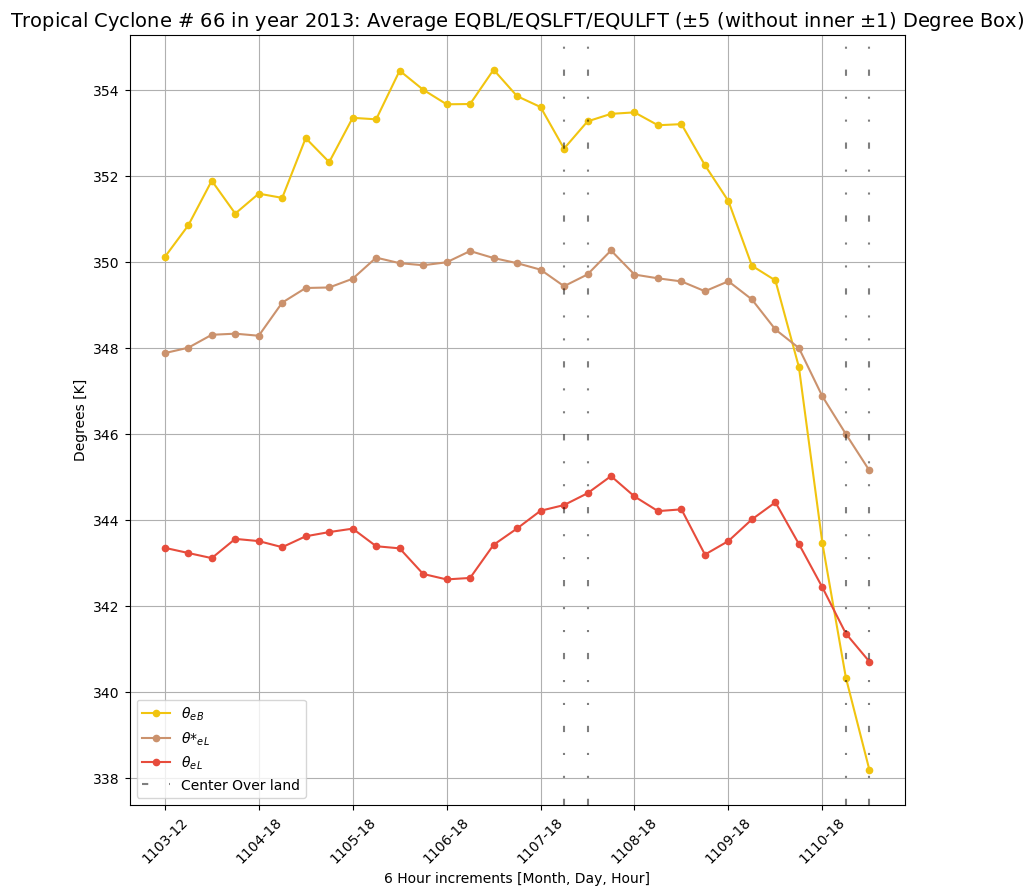

In [20]:
off_check = offset[0]-internal
off_range = (2*offset[0])-.25
lat_array=tcs.tc_tracks[tc_number]['lat']
lon_array=tcs.tc_tracks[tc_number]['lon']
g = np.int_(np.linspace(0,tcs.ds_comp[tc_number].precipitation.time.size-1)) #so I get the exact number of frames
x = np.arange(0,max(g)+1,1)
eqblext = [0] * len(x) #empty array for EQBL
eqslftext= [0] * len(x) #empty array for EQSLFT
equlftext = [0] * len(x) #empty array for EQULFT
subsext = [0] * len(x) #empty array for subsaturation
capeext = [0] * len(x) #empty array for CAPE
buoyext = [0] * len(x) #empty array for buoyancy
preciext = [0] * len(x) #empty array for precipitation 
box_size = []


for t in range(max(g)+1):
        
    
    eqbl= tcs.ds_comp[tc_number].EQBL.isel(time=t) #taking the values for equivalent pot. temp. in the ABL
    eqblada=eqbl.stack(x=['lon','lat'])
    eqbla=eqblada[eqblada.notnull()] #so I can manipulate the values for this factor and take the inside and outside

    eqslft= tcs.ds_comp[tc_number].EQSLFT.isel(time=t) #taking the values for equivalent sat. pot. temp. in the LFT
    eqslftada=eqslft.stack(x=['lat','lon'])
    eqslfta=eqslftada[eqslftada.notnull()]

    equlft= tcs.ds_comp[tc_number].EQULFT.isel(time=t) #taking the values for equivalent unsat. pot. temp. in the LFT
    equlftada=equlft.stack(x=['lat','lon'])
    equlfta=equlftada[equlftada.notnull()]

    subs= tcs.ds_comp[tc_number].Subsaturation.isel(time=t) #taking the values for subsaturation in the LFT
    subsada_stacked=subs.stack(x=['lat','lon'])
    subsa=subsada_stacked[subsada_stacked.notnull()]

    cape= tcs.ds_comp[tc_number].CAPE.isel(time=t) #taking the values for CAPE in the LFT
    capada_stacked=cape.stack(x=['lat','lon'])
    capea=capada_stacked[capada_stacked.notnull()]

    buoy= tcs.ds_comp[tc_number].Buoyancy.isel(time=t) #taking the buoyancy for buoyancy in the LFT
    buoyada=buoy.stack(x=['lat','lon'])
    buoya=buoyada[buoyada.notnull()]

    preci= tcs.ds_comp[tc_number].precipitation.isel(time=t) #taking the values for precipitation
    preciada=preci.stack(x=['lat','lon'])
    precia=preciada[preciada.notnull()]
    if len(eqblada.lon.values) == 0:
        
        eqblext[t]=(float("nan")) #for storms that have no values to calculate (above/below 35 N/S)
        eqslftext[t]=(float("nan"))
        equlftext[t]=(float("nan"))
        subsext[t]=(float("nan"))
        capeext[t]=(float("nan"))
        buoyext[t]=(float("nan"))
        preciext[t]=(float("nan"))
        box_size.append(t)
    else:
        r=max(eqblada.lon.values)
        o=min(eqblada.lon.values)
        pp=o+off_check
        qq=r-off_check
        
        eqblaorder=eqbla.sortby(eqbla.lat)
        rr=max(eqblaorder.lat.values)
        oo=min(eqblaorder.lat.values)
        if rr-oo == off_range: #for the box when full sized
            p=oo+off_check
            q=rr-off_check
            eqbl_check = eqbla.where((eqbla.lon<=pp) | (eqbla.lon>=qq) | (eqbla.lat<=p) | (eqbla.lat>=q))
            eqslft_check = eqslfta.where((eqslfta.lon<=pp) | (eqslfta.lon>=qq) | (eqslfta.lat<=p) | (eqslfta.lat>=q))
            equlft_check = equlfta.where((equlfta.lon<=pp) | (equlfta.lon>=qq) | (equlfta.lat<=p) | (equlfta.lat>=q))
            
            subs_check = subsa.where((subsa.lon<=pp) | (subsa.lon>=qq) | (subsa.lat<=p) | (subsa.lat>=q))
            cape_check = capea.where((capea.lon<=pp) | (capea.lon>=qq) | (capea.lat<=p) | (capea.lat>=q))
            
            buoy_check = buoya.where((buoya.lon<=pp) | (buoya.lon>=qq) | (buoya.lat<=p) | (buoya.lat>=q))
            preci_check = precia.where((precia.lon<=pp) | (precia.lon>=qq) | (precia.lat<=p) | (precia.lat>=q))

            box_size.append("x")
        elif (rr-oo < off_range) & (rr-oo >= (off_check+2.5)) & (lat_array[0] > 0): 
            #for when the box's northern end is less than complete, and cuts part of the top
            p=oo+off_check
            offer = off_range-(rr-oo)
            off_fix=off_check-offer
            q=rr-off_fix
            eqbl_check = eqbla.where((eqbla.lon<=pp) | (eqbla.lon>=qq) | (eqbla.lat<=p) | (eqbla.lat>=q))
            eqslft_check = eqslfta.where((eqslfta.lon<=pp) | (eqslfta.lon>=qq) | (eqslfta.lat<=p) | (eqslfta.lat>=q))
            equlft_check = equlfta.where((equlfta.lon<=pp) | (equlfta.lon>=qq) | (equlfta.lat<=p) | (equlfta.lat>=q))
            
            subs_check = subsa.where((subsa.lon<=pp) | (subsa.lon>=qq) | (subsa.lat<=p) | (subsa.lat>=q))
            cape_check = capea.where((capea.lon<=pp) | (capea.lon>=qq) | (capea.lat<=p) | (capea.lat>=q))
            
            buoy_check = buoya.where((buoya.lon<=pp) | (buoya.lon>=qq) | (buoya.lat<=p) | (buoya.lat>=q))
            preci_check = precia.where((precia.lon<=pp) | (precia.lon>=qq) | (precia.lat<=p) | (precia.lat>=q))
            box_size.append(t)
        elif (rr-oo > off_check) & (rr-oo < (off_check+2.5)) & (lat_array[0] > 0):
            #for when the box's northern end is less than complete, and cuts into the internal part of the box
            p=oo+off_check
            q=rr
            eqbl_check = eqbla.where((eqbla.lon<=pp) | (eqbla.lon>=qq) | (eqbla.lat<=p) | (eqbla.lat>=q))
            eqslft_check = eqslfta.where((eqslfta.lon<=pp) | (eqslfta.lon>=qq) | (eqslfta.lat<=p) | (eqslfta.lat>=q))
            equlft_check = equlfta.where((equlfta.lon<=pp) | (equlfta.lon>=qq) | (equlfta.lat<=p) | (equlfta.lat>=q))
            
            subs_check = subsa.where((subsa.lon<=pp) | (subsa.lon>=qq) | (subsa.lat<=p) | (subsa.lat>=q))
            cape_check = capea.where((capea.lon<=pp) | (capea.lon>=qq) | (capea.lat<=p) | (capea.lat>=q))
            
            buoy_check = buoya.where((buoya.lon<=pp) | (buoya.lon>=qq) | (buoya.lat<=p) | (buoya.lat>=q))
            preci_check = precia.where((precia.lon<=pp) | (precia.lon>=qq) | (precia.lat<=p) | (precia.lat>=q))
            box_size.append(t)
        elif (rr-oo < off_range) & (rr-oo >= (off_check+2.5)) & (lat_array[0] < 0):
            #for when the box's southern end is less than complete, and cuts part of the bottom
            offer = off_range-(rr-oo)
            off_fix=off_check-offer
            p=oo+off_fix
            q=rr-off_check
            eqbl_check = eqbla.where((eqbla.lon<=pp) | (eqbla.lon>=qq) | (eqbla.lat<=p) | (eqbla.lat>=q))
            eqslft_check = eqslfta.where((eqslfta.lon<=pp) | (eqslfta.lon>=qq) | (eqslfta.lat<=p) | (eqslfta.lat>=q))
            equlft_check = equlfta.where((equlfta.lon<=pp) | (equlfta.lon>=qq) | (equlfta.lat<=p) | (equlfta.lat>=q))
            
            subs_check = subsa.where((subsa.lon<=pp) | (subsa.lon>=qq) | (subsa.lat<=p) | (subsa.lat>=q))
            cape_check = capea.where((capea.lon<=pp) | (capea.lon>=qq) | (capea.lat<=p) | (capea.lat>=q))
            
            buoy_check = buoya.where((buoya.lon<=pp) | (buoya.lon>=qq) | (buoya.lat<=p) | (buoya.lat>=q))
            preci_check = precia.where((precia.lon<=pp) | (precia.lon>=qq) | (precia.lat<=p) | (precia.lat>=q))
            box_size.append(t)
        elif (rr-oo > off_check) & (rr-oo < (off_check+2.5)) & (lat_array[0] < 0):
            #for when the box's southern end is less than complete, and cuts into the internal part of the box
            p=oo
            q=rr-off_check
            eqbl_check = eqbla.where((eqbla.lon<=pp) | (eqbla.lon>=qq) | (eqbla.lat<=p) | (eqbla.lat>=q))
            eqslft_check = eqslfta.where((eqslfta.lon<=pp) | (eqslfta.lon>=qq) | (eqslfta.lat<=p) | (eqslfta.lat>=q))
            equlft_check = equlfta.where((equlfta.lon<=pp) | (equlfta.lon>=qq) | (equlfta.lat<=p) | (equlfta.lat>=q))
            
            subs_check = subsa.where((subsa.lon<=pp) | (subsa.lon>=qq) | (subsa.lat<=p) | (subsa.lat>=q))
            cape_check = capea.where((capea.lon<=pp) | (capea.lon>=qq) | (capea.lat<=p) | (capea.lat>=q))
            
            buoy_check = buoya.where((buoya.lon<=pp) | (buoya.lon>=qq) | (buoya.lat<=p) | (buoya.lat>=q))
            preci_check = precia.where((precia.lon<=pp) | (precia.lon>=qq) | (precia.lat<=p) | (precia.lat>=q))
            box_size.append(t)
        
        else:
            #for when the internal value is cut out
            eqbl_check = eqbla
            eqslft_check = eqslfta
            equlft_check = equlfta
            subs_check = subsa
            cape_check = capea
            buoy_check = buoya
            preci_check = precia
            box_size.append(t)
    eqblext[t] = np.nanmean(eqbl_check)
    eqslftext[t] = np.nanmean(eqslft_check)
    equlftext[t] = np.nanmean(equlft_check)
    subsext[t] = np.nanmean(subs_check)
    capeext[t] = np.nanmean(cape_check)
    buoyext[t] = np.nanmean(buoy_check)
    preciext[t] = np.nanmean(preci_check)



time_array = []
x = np.arange(0,max(g)+1,1)
for t in range(max(g)+1):
    v = tcs.ds_comp[tc_number].time.dt.strftime("%m%d-%H").isel(time=t).item()
    time_array.append(v)
plt.figure(figsize = (10,10))
plt.xticks(x, time_array, rotation = 45)
plt.locator_params(axis='x', nbins=len(x)/4)
plt.plot(x,eqblext, color='#F1C40F', marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$")
plt.plot(x,eqslftext, color='#CB926D', marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$")
plt.plot(x,equlftext, color='#E74C3C', marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$")
teste = []
testee = []
for na in eqblext:
    if np.isnan(na):
        te.append(na)
    else:
        tes.append(na)
if len(te) != 0:
    leng = len(tes)
    plt.axvline(x=x[leng-1], linestyle ="--", color="k", label = "Storm Passes 35{} N/S, Persists {} More Hours".format(chr(176), 6*len(te)))
breaks = 0 #so the label doesn't repeat
for lin in range(len(eqblext)): #so I can show what times a storm box is not full size

    if (type(box_size[lin]) == int) & (breaks != 0): #so the label doesn't repeat
        
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B")
    if (type(box_size[lin]) == int) & (breaks == 0):
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B", label = "Box is Not Full Size")
        breaks = breaks + 1
        
breaker = 0 #so the label doesn't repeat
for lan in range(len(eqblext)): #so I can show what time values have a storm on land
    if lon_array[lan] >= 180: #to correct the landmask
        lon_array[lan] = lon_array[lan]-360
    if globe.is_land(lat_array[lan], lon_array[lan]) == True:
        if breaker != 0: #so the label doesn't repeat
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5)
        if breaker == 0:
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5, label = "Center Over land")
            breaker = breaker + 1

plt.grid()
plt.legend()
plt.xlabel("6 Hour increments [Month, Day, Hour]", fontsize = 10)

plt.ylabel("Degrees [K]", fontsize = 10)

plt.title('Tropical Cyclone # {:d} in year {:d}: Average EQBL/EQSLFT/EQULFT ($\u00B1${} (without inner $\u00B1${}) Degree Box)'.format(tc_number,year,offset[0],internal),fontsize=14);

# Plots the Internal Values and the External Values

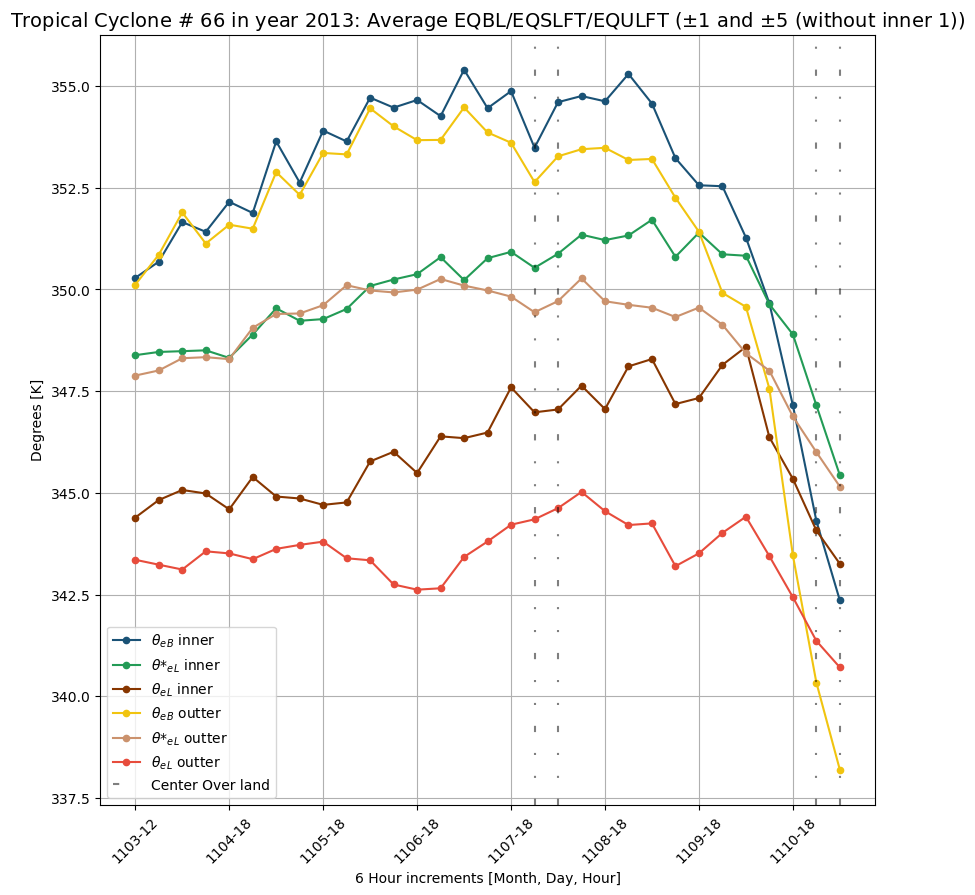

In [30]:
lat_array=tcs.tc_tracks[tc_number]['lat']
lon_array=tcs.tc_tracks[tc_number]['lon']
time_array = [] #creating time array so I can include the dates properly
x = np.arange(0,max(g)+1,1)
for t in range(max(g)+1):
    v = tcs.ds_comp[tc_number].time.dt.strftime("%m%d-%H").isel(time=t).item()
    time_array.append(v)
plt.figure(figsize = (10,10))
plt.xticks(x, time_array, rotation = 45)
plt.locator_params(axis='x', nbins=len(x)/4)
plt.plot(x,eqblint, color='#1A5276', marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$ inner")
plt.plot(x,eqslftint, color='#239B56', marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$ inner")
plt.plot(x,equlftint, color='#873600', marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$ inner")
plt.plot(x,eqblext, color='#F1C40F', marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$ outter")
plt.plot(x,eqslftext, color='#CB926D', marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$ outter")
plt.plot(x,equlftext, color='#E74C3C', marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$ outter")
teste = []
testee = []
for na in eqblint:
    if np.isnan(na):
        te.append(na)
    else:
        tes.append(na)
if len(te) != 0:
    leng = len(tes)
    plt.axvline(x=x[leng-1], linestyle ="--", color="k", label = "Storm Passes 35{} N/S, Persists {} More Hours".format(chr(176), 6*len(te)))
breaks = 0 #so the label doesn't repeat
for lin in range(len(eqblint)): #so I can show what times a storm box is not full size

    if (type(box_size[lin]) == int) & (breaks != 0): #so the label doesn't repeat
        
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B")
    if (type(box_size[lin]) == int) & (breaks == 0):
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B", label = "Box is Not Full Size")
        breaks = breaks + 1
        
breaker = 0 #so the label doesn't repeat
for lan in range(len(eqblint)): #so I can show what time values have a storm on land
    if lon_array[lan] >= 180: #to correct the landmask
        lon_array[lan] = lon_array[lan]-360
    if globe.is_land(lat_array[lan], lon_array[lan]) == True:
        if breaker != 0: #so the label doesn't repeat
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5)
        if breaker == 0:
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5, label = "Center Over land")
            breaker = breaker + 1
plt.grid()
plt.legend()
plt.xlabel("6 Hour increments [Month, Day, Hour]", fontsize = 10)

plt.ylabel("Degrees [K]", fontsize = 10)

plt.title('Tropical Cyclone # {:d} in year {:d}: Average EQBL/EQSLFT/EQULFT ($\u00B1${} and $\u00B1${} (without inner {}))'.format(tc_number,year,internal, offset[0],internal),fontsize=14);


# Subtracts the External Average from the Internal Value and Plots

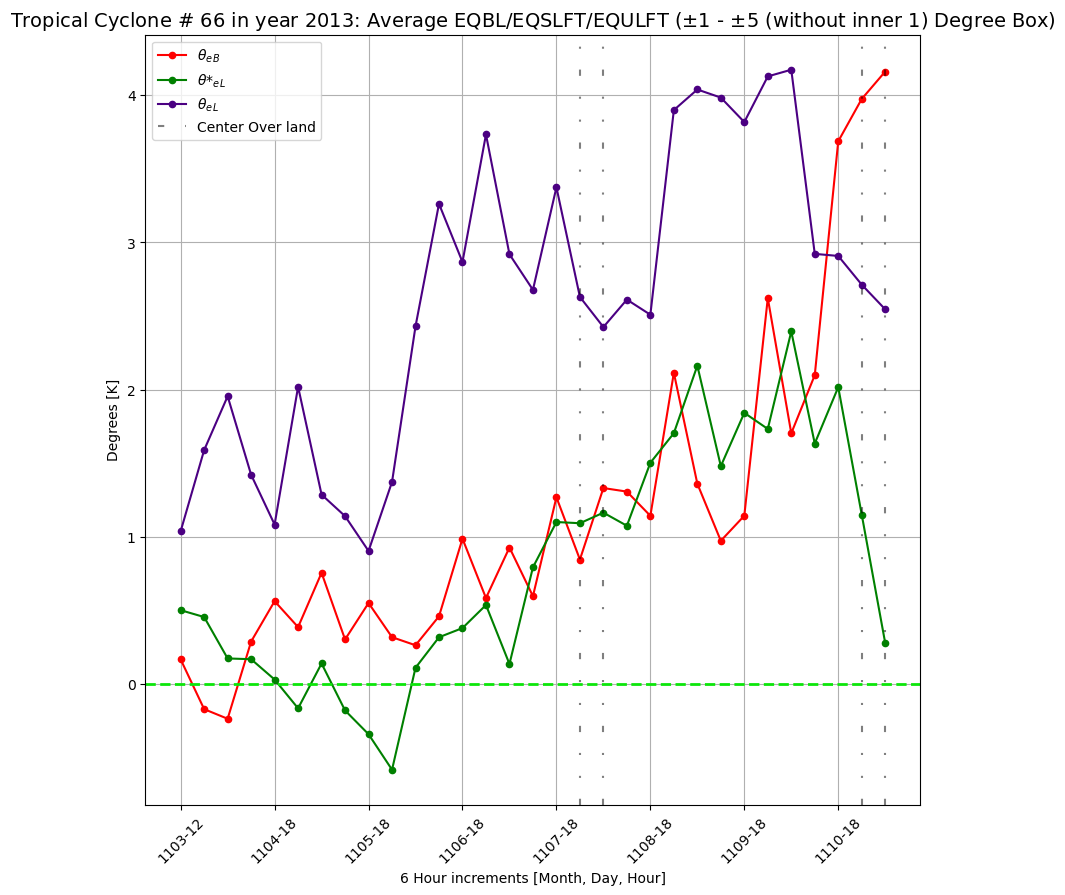

In [31]:
lat_array=tcs.tc_tracks[tc_number]['lat']
lon_array=tcs.tc_tracks[tc_number]['lon']
x = np.arange(0,max(g)+1,1)
EQBL_weight_unweight = [0] * len(x) #creating empty array to take the difference between internal and external
for i in x:
    EQBL_weight_unweight[i]= (eqblint[i] - eqblext[i]) #taking the difference between internal and external average


EQSLFT_weight_unweight  = [0] * len(x)
for i in x:
    EQSLFT_weight_unweight[i]= (eqslftint[i] - eqslftext[i])


EQULFT_weight_unweight  = [0] * len(x)
for i in x:
    EQULFT_weight_unweight[i]= (equlftint[i] - equlftext[i])

Subsat_weight_unweight = [0] * len(x)
for i in x:
    Subsat_weight_unweight[i]= (subsint[i] - subsext[i])

CAPE_weight_unweight = [0] * len(x)
for i in x:
    CAPE_weight_unweight[i]= (capeint[i] - capeext[i])

Buoy_weight_unweight = [0] * len(x)
for i in x:
    Buoy_weight_unweight[i]= (buoyint[i] - buoyext[i]) 

Precip_weight_unweight = [0] * len(x)
for i in x:
    Precip_weight_unweight[i]= (preciint[i] - preciext[i]) 

time_array = []
#x = np.arange(0,max(g)+1,1)
for t in range(max(g)+1):
    v = tcs.ds_comp[tc_number].time.dt.strftime("%m%d-%H").isel(time=t).item()
    time_array.append(v)
plt.figure(figsize = (10,10))
plt.xticks(x, time_array, rotation = 45)
plt.locator_params(axis='x', nbins=len(x)/4)
plt.plot(x,EQBL_weight_unweight, color='r', marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$")
plt.plot(x,EQSLFT_weight_unweight, color="g", marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$")
plt.plot(x,EQULFT_weight_unweight, color="indigo", marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$")
plt.axhline(y=0, linestyle ="--", color="#0CE60A",linewidth=2)
teste = []
testee = []
for na in eqblint:
    if np.isnan(na):
        te.append(na)
    else:
        tes.append(na)
if len(te) != 0:
    leng = len(tes)
    plt.axvline(x=x[leng-1], linestyle ="--", color="k", label = "Storm Passes 35{} N/S, Persists {} More Hours".format(chr(176), 6*len(te)))
breaks = 0 #so the label doesn't repeat
for lin in range(len(eqblint)): #so I can show what times a storm box is not full size

    if (type(box_size[lin]) == int) & (breaks != 0): #so the label doesn't repeat
        
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B")
    if (type(box_size[lin]) == int) & (breaks == 0):
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B", label = "Box is Not Full Size")
        breaks = breaks + 1
        
breaker = 0 #so the label doesn't repeat
for lan in range(len(eqblint)): #so I can show what time values have a storm on land
    if lon_array[lan] >= 180: #to correct the landmask
        lon_array[lan] = lon_array[lan]-360
    if globe.is_land(lat_array[lan], lon_array[lan]) == True:
        if breaker != 0: #so the label doesn't repeat
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5)
        if breaker == 0:
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5, label = "Center Over land")
            breaker = breaker + 1
plt.grid()
plt.legend()
plt.xlabel("6 Hour increments [Month, Day, Hour]", fontsize = 10)

plt.ylabel("Degrees [K]", fontsize = 10)

plt.title('Tropical Cyclone # {:d} in year {:d}: Average EQBL/EQSLFT/EQULFT ($\u00B1${} - $\u00B1${} (without inner {}) Degree Box)'.format(tc_number,year, internal,offset[0],internal),fontsize=14);

# Takes all Previous Graphs From Above and Combines them into a Subplot Group

/tmp/ipykernel_142615/1143247643.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


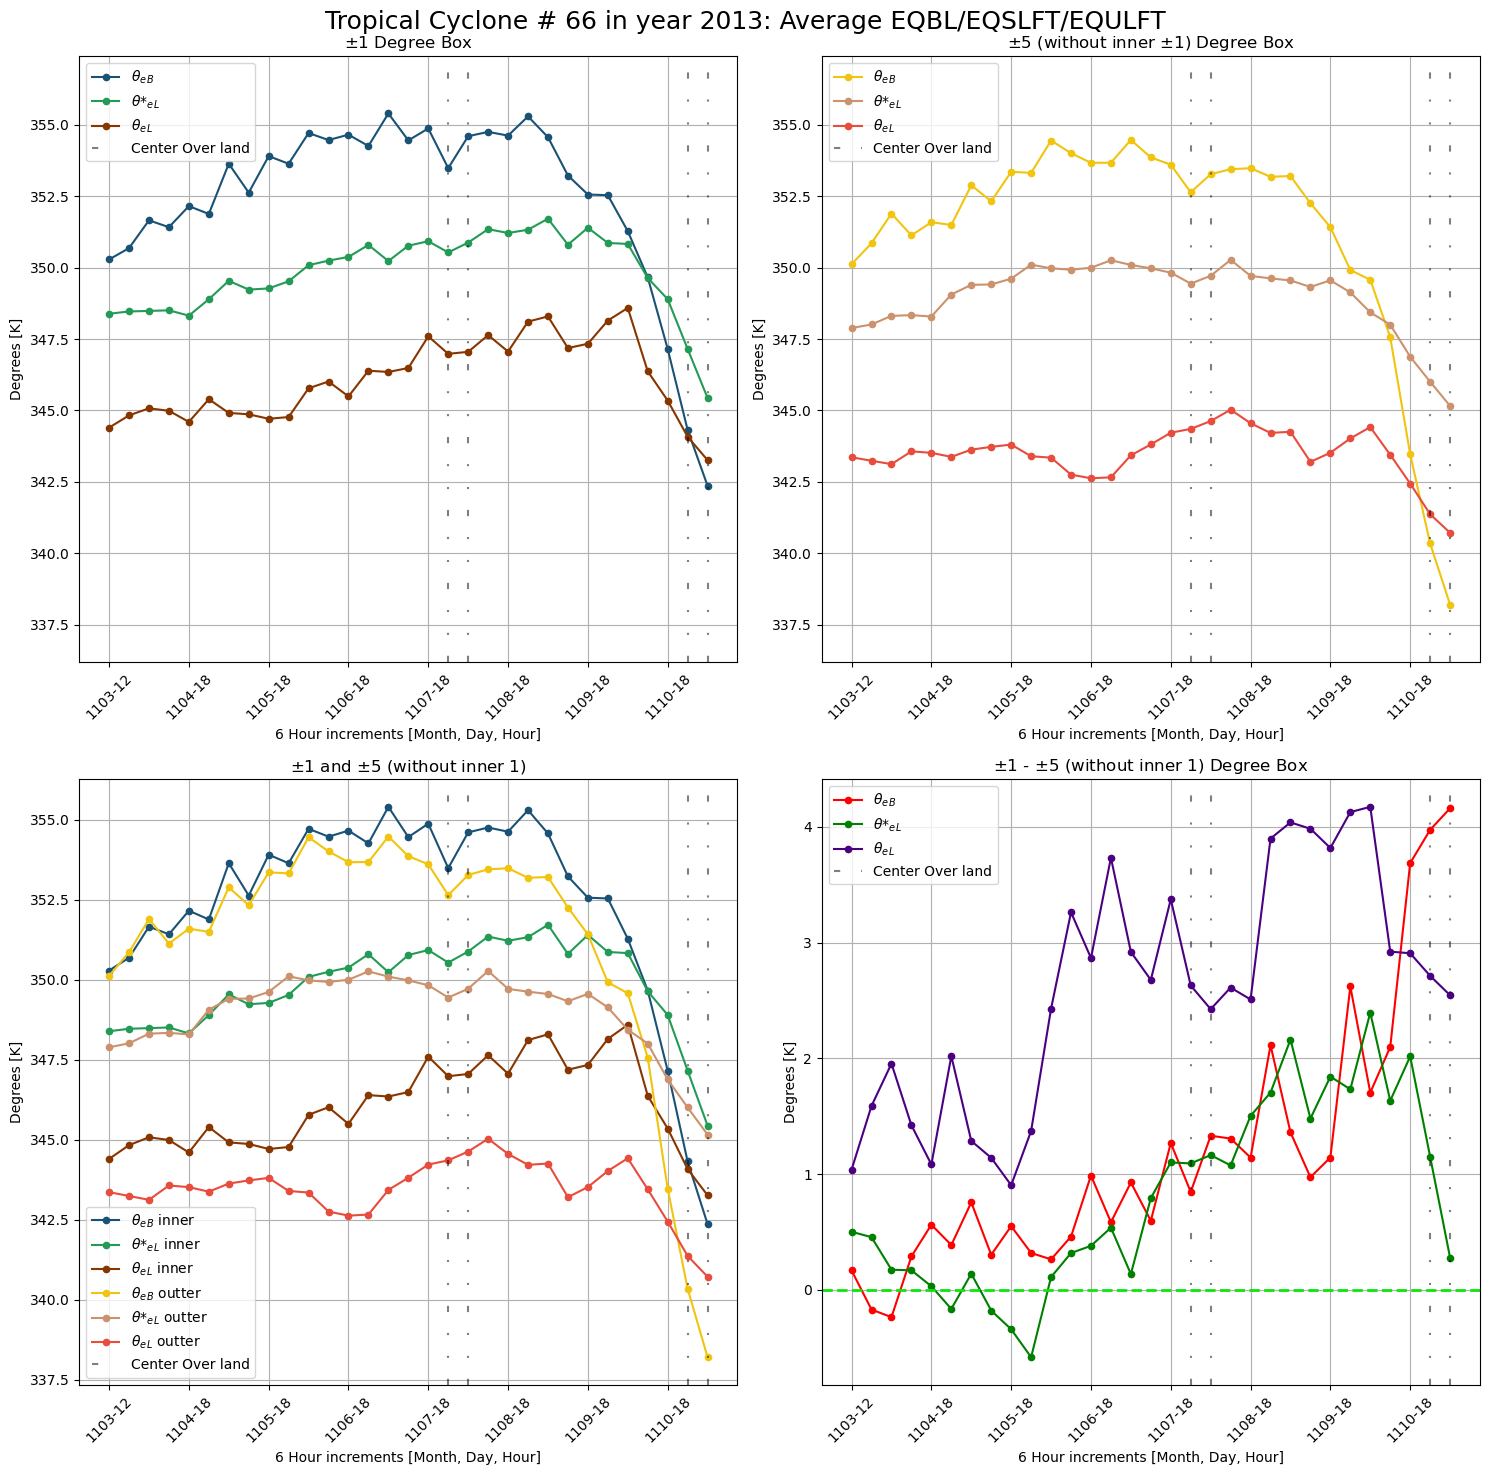

In [35]:
plt.subplots(figsize = (15,15))

minim=min(np.min(eqblext),np.min(eqslftext),np.min(equlftext))
maxi=max(np.max(eqblint),np.max(eqslftint),np.max(equlftint))

plt.subplot(2,2,1)
plt.xticks(x, time_array, rotation = 45)
plt.locator_params(axis='x', nbins=len(x)/4)
plt.plot(x,eqblint, color='#1A5276', marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$")
plt.plot(x,eqslftint, color='#239B56', marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$")
plt.plot(x,equlftint, color='#873600', marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$")
teste = [] #calculates when the storm's center passes 35 N/S
testee = []
for na in eqblint:
    if np.isnan(na):
        te.append(na)
    else:
        tes.append(na)
if len(te) != 0:
    leng = len(tes)
    plt.axvline(x=x[leng-1], linestyle ="--", color="k", label = "Storm Passes 35{} N/S, Persists {} More Hours".format(chr(176), 6*len(te)))
breaks = 0 #so the label doesn't repeat
for lin in range(len(eqblint)): #so I can show what times a storm box is not full size

    if (type(box_size[lin]) == int) & (breaks != 0): #so the label doesn't repeat
        
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B")
    if (type(box_size[lin]) == int) & (breaks == 0):
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B", label = "Box is Not Full Size")
        breaks = breaks + 1
        
breaker = 0 #so the label doesn't repeat
for lan in range(len(eqblint)): #so I can show what time values have a storm on land
    if lon_array[lan] >= 180: #to correct the landmask
        lon_array[lan] = lon_array[lan]-360
    if globe.is_land(lat_array[lan], lon_array[lan]) == True:
        if breaker != 0: #so the label doesn't repeat
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5)
        if breaker == 0:
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5, label = "Center Over land")
            breaker = breaker + 1
plt.grid()
plt.ylim(minim-2, maxi+2)
plt.legend()
plt.xlabel("6 Hour increments [Month, Day, Hour]", fontsize = 10)

plt.ylabel("Degrees [K]", fontsize = 10)

plt.title('$\u00B1${} Degree Box'.format(internal),fontsize=12);

plt.subplot(2,2,2)
plt.xticks(x, time_array, rotation = 45)
plt.locator_params(axis='x', nbins=len(x)/4)
plt.plot(x,eqblext, color='#F1C40F', marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$")
plt.plot(x,eqslftext, color='#CB926D', marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$")
plt.plot(x,equlftext, color='#E74C3C', marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$")
teste = [] #calculates when the storm's center passes 35 N/S
testee = []
for na in eqblext:
    if np.isnan(na):
        te.append(na)
    else:
        tes.append(na)
if len(te) != 0:
    leng = len(tes)
    plt.axvline(x=x[leng-1], linestyle ="--", color="k", label = "Storm Passes 35{} N/S, Persists {} More Hours".format(chr(176), 6*len(te)))
breaks = 0 #so the label doesn't repeat
for lin in range(len(eqblext)): #so I can show what times a storm box is not full size

    if (type(box_size[lin]) == int) & (breaks != 0): #so the label doesn't repeat
        
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B")
    if (type(box_size[lin]) == int) & (breaks == 0):
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B", label = "Box is Not Full Size")
        breaks = breaks + 1
        
breaker = 0 #so the label doesn't repeat
for lan in range(len(eqblext)): #so I can show what time values have a storm on land
    if lon_array[lan] >= 180: #to correct the landmask
        lon_array[lan] = lon_array[lan]-360
    if globe.is_land(lat_array[lan], lon_array[lan]) == True:
        if breaker != 0: #so the label doesn't repeat
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5)
        if breaker == 0:
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5, label = "Center Over land")
            breaker = breaker + 1
plt.grid()
plt.ylim(minim-2, maxi+2)
plt.legend()
plt.xlabel("6 Hour increments [Month, Day, Hour]", fontsize = 10)

plt.ylabel("Degrees [K]", fontsize = 10)

plt.title('$\u00B1${} (without inner $\u00B1${}) Degree Box'.format(offset[0],internal),fontsize=12);

plt.subplot(2,2,3)

plt.xticks(x, time_array, rotation = 45)
plt.locator_params(axis='x', nbins=len(x)/4)
plt.plot(x,eqblint, color='#1A5276', marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$ inner")
plt.plot(x,eqslftint, color='#239B56', marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$ inner")
plt.plot(x,equlftint, color='#873600', marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$ inner")
plt.plot(x,eqblext, color='#F1C40F', marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$ outter")
plt.plot(x,eqslftext, color='#CB926D', marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$ outter")
plt.plot(x,equlftext, color='#E74C3C', marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$ outter")
teste = [] #calculates when the storm's center passes 35 N/S
testee = []
for na in eqblint:
    if np.isnan(na):
        te.append(na)
    else:
        tes.append(na)
if len(te) != 0:
    leng = len(tes)
    plt.axvline(x=x[leng-1], linestyle ="--", color="k", label = "Storm Passes 35{} N/S, Persists {} More Hours".format(chr(176), 6*len(te)))
breaks = 0 #so the label doesn't repeat
for lin in range(len(eqblint)): #so I can show what times a storm box is not full size

    if (type(box_size[lin]) == int) & (breaks != 0): #so the label doesn't repeat
        
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B")
    if (type(box_size[lin]) == int) & (breaks == 0):
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B", label = "Box is Not Full Size")
        breaks = breaks + 1
        
breaker = 0 #so the label doesn't repeat
for lan in range(len(eqblint)): #so I can show what time values have a storm on land
    if lon_array[lan] >= 180: #to correct the landmask
        lon_array[lan] = lon_array[lan]-360
    if globe.is_land(lat_array[lan], lon_array[lan]) == True:
        if breaker != 0: #so the label doesn't repeat
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5)
        if breaker == 0:
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5, label = "Center Over land")
            breaker = breaker + 1
plt.grid()
plt.legend()
plt.xlabel("6 Hour increments [Month, Day, Hour]", fontsize = 10)

plt.ylabel("Degrees [K]", fontsize = 10)

plt.title('$\u00B1${} and $\u00B1${} (without inner {})'.format(internal,offset[0],internal),fontsize=12);

plt.subplot(2,2,4)
plt.xticks(x, time_array, rotation = 45)
plt.locator_params(axis='x', nbins=len(x)/4)
plt.plot(x,EQBL_weight_unweight, color='r', marker = '.', markersize = 9, label = "$\\theta$$_e$$_B$")
plt.plot(x,EQSLFT_weight_unweight, color="g", marker = '.', markersize = 9, label = "$\\theta$*$_e$$_L$")
plt.plot(x,EQULFT_weight_unweight, color="indigo", marker = '.', markersize = 9, label = "$\\theta$$_e$$_L$")
plt.axhline(y=0, linestyle ="--", color="#0CE60A",linewidth=2) 
#positive = internal has higher values
#negative = external has higher values
teste = [] #calculates when the storm's center passes 35 N/S
testee = []
for na in eqblint:
    if np.isnan(na):
        te.append(na)
    else:
        tes.append(na)
if len(te) != 0:
    leng = len(tes)
    plt.axvline(x=x[leng-1], linestyle ="--", color="k", label = "Storm Passes 35{} N/S, Persists {} More Hours".format(chr(176), 6*len(te)))
breaks = 0 #so the label doesn't repeat
for lin in range(len(eqblint)): #so I can show what times a storm box is not full size

    if (type(box_size[lin]) == int) & (breaks != 0): #so the label doesn't repeat
        
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B")
    if (type(box_size[lin]) == int) & (breaks == 0):
        plt.axvline(x=x[lin], linestyle =(0, (3, 1, 1, 1, 1, 1)), color="#838B8B", label = "Box is Not Full Size")
        breaks = breaks + 1
        
breaker = 0 #so the label doesn't repeat
for lan in range(len(eqblint)): #so I can show what time values have a storm on land
    if lon_array[lan] >= 180: #to correct the landmask
        lon_array[lan] = lon_array[lan]-360
    if globe.is_land(lat_array[lan], lon_array[lan]) == True:
        if breaker != 0: #so the label doesn't repeat
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5)
        if breaker == 0:
            plt.axvline(x=x[lan], linestyle =(0, (3, 10, 1, 10, 1, 10)), color="k", alpha = .5, label = "Center Over land")
            breaker = breaker + 1

plt.grid()
plt.legend()
plt.xlabel("6 Hour increments [Month, Day, Hour]", fontsize = 10)

plt.ylabel("Degrees [K]", fontsize = 10)

plt.title('$\u00B1${} - $\u00B1${} (without inner {}) Degree Box'.format(internal,offset[0],internal),fontsize=12);
plt.suptitle('Tropical Cyclone # {:d} in year {:d}: Average EQBL/EQSLFT/EQULFT'.format(tc_number,year),fontsize=18);
plt.tight_layout()

# Takes the Internal Minus the External For Every Tropical Cyclone that Landfalls and is within the Tropics

In [11]:

for v in landfall: #taking every storm that landfalls and have a complete box in the tropics
    print(v)
    eqblint = [] #empty array for EQBL (internal)
    eqslftint= [] #empty array for EQSLFT (internal)
    equlftint = [] #empty array for EQULFT (internal)
    subsint = [] #empty array for subsaturation (internal)
    capeint = [] #empty array for CAPE (internal)
    buoyint = [] #empty array for buoyancy (internal)
    preciint = [] #empty array for precipitation (internal)
    
    
    
    eqblext = [] #empty array for EQBL (external)
    eqslftext= [] #empty array for EQSLFT (external)
    equlftext = [] #empty array for EQULFT (external)
    subsext = [] #empty array for subsaturation (external)
    capeext = [] #empty array for CAPE (external)
    buoyext = [] #empty array for buoyancy (external)
    preciext = [] #empty array for precipitation (external)
    
    tc_number = v
    lat_array=tcs.tc_tracks[tc_number]['lat'] #take latitude and longitude array
    lon_array=tcs.tc_tracks[tc_number]['lon'] 
    psl=tcs.tc_tracks[tc_number]['psl'] #takes the array of pressure at each storm's timestep
    maxwind=tcs.tc_tracks[tc_number]['maxwind'] #takes the array of max wind at each storm's timestep
    g = np.int_(np.linspace(0,tcs.ds_comp[tc_number].precipitation.time.size-1)) #so I get the exact number of frames
    x = 0
    for t in range(max(g)+1):
        eqbl= tcs.ds_comp[tc_number].EQBL.isel(time=t) #taking the values for equivalent pot. temp. in the ABL
        eqblada=eqbl.stack(x=['lon','lat'])
        eqbla=eqblada[eqblada.notnull()] #so I can manipulate the values for this factor and take the inside and outside
    
        eqslft= tcs.ds_comp[tc_number].EQSLFT.isel(time=t) #taking the values for equivalent sat. pot. temp. in the LFT
        eqslftada=eqslft.stack(x=['lat','lon'])
        eqslfta=eqslftada[eqslftada.notnull()]
    
        equlft= tcs.ds_comp[tc_number].EQULFT.isel(time=t) #taking the values for equivalent unsat. pot. temp. in the LFT
        equlftada=equlft.stack(x=['lat','lon'])
        equlfta=equlftada[equlftada.notnull()]
        
        subs= tcs.ds_comp[tc_number].Subsaturation.isel(time=t) #taking the values for subsaturation in the LFT
        subsada_stacked=subs.stack(x=['lat','lon'])
        subsa=subsada_stacked[subsada_stacked.notnull()]
        
        cape= tcs.ds_comp[tc_number].CAPE.isel(time=t) #taking the values for CAPE in the LFT
        capada_stacked=cape.stack(x=['lat','lon'])
        capea=capada_stacked[capada_stacked.notnull()]
    
        buoy= tcs.ds_comp[tc_number].Buoyancy.isel(time=t) #taking the buoyancy for buoyancy in the LFT
        buoyada=buoy.stack(x=['lat','lon'])
        buoya=buoyada[buoyada.notnull()]
        
        preci= tcs.ds_comp[tc_number].precipitation.isel(time=t) #taking the values for precipitation
        preciada=preci.stack(x=['lat','lon'])
        precia=preciada[preciada.notnull()]
        
        if len(eqbla.lon.values) == 0:
            continue #so I can filter out storms outside of +- 35 degrees
        r=max(eqbla.lon.values) #maximal box value for longitude
        o=min(eqbla.lon.values) #minimal box value for longitude
        pp=o+off_check #so I can get the internal box minimal longitude
        qq=r-off_check #so I can get the internal box maximal longitude

        
        eqblaorder=eqbla.sortby(eqbla.lat) #since latitude values are out of order
        rr=max(eqblaorder.lat.values) #maximal box value for latitude
        oo=min(eqblaorder.lat.values) #minimal box value for latitude
        if rr-oo == off_range:
            p=oo+off_check #so I can get the internal box minimal longitude
            q=rr-off_check #so I can get the internal box maximal longitude
            #Taking the environment outside of the internal box of degree(internal)
            eqbl_check = eqbla.where((eqbla.lon<=pp) | (eqbla.lon>=qq) | (eqbla.lat<=p) | (eqbla.lat>=q))
            eqslft_check = eqslfta.where((eqslfta.lon<=pp) | (eqslfta.lon>=qq) | (eqslfta.lat<=p) | (eqslfta.lat>=q))
            equlft_check = equlfta.where((equlfta.lon<=pp) | (equlfta.lon>=qq) | (equlfta.lat<=p) | (equlfta.lat>=q))
            
            subs_check = subsa.where((subsa.lon<=pp) | (subsa.lon>=qq) | (subsa.lat<=p) | (subsa.lat>=q))
            cape_check = capea.where((capea.lon<=pp) | (capea.lon>=qq) | (capea.lat<=p) | (capea.lat>=q))
            
            buoy_check = buoya.where((buoya.lon<=pp) | (buoya.lon>=qq) | (buoya.lat<=p) | (buoya.lat>=q))
            preci_check = precia.where((precia.lon<=pp) | (precia.lon>=qq) | (precia.lat<=p) | (precia.lat>=q))
            x = x + 1
        else:
            continue
        eqbl_place=np.nanmean(eqbl_check) #averaging all the values outside of the internal box
        eqslft_place=np.nanmean(eqslft_check)
        equlft_place=np.nanmean(equlft_check)
        
        subs_place=np.nanmean(subs_check)
        cape_place=np.nanmean(cape_check)
        
        buoy_place=np.nanmean(buoy_check)
        preci_place=np.nanmean(preci_check)
        
        eqblext.append(eqbl_place) #appending to the external list
        eqslftext.append(eqslft_place)
        equlftext.append(equlft_place)
        subsext.append(subs_place)
        capeext.append(cape_place)
        buoyext.append(buoy_place)
        preciext.append(preci_place)

        if rr-oo == off_range:
            p=oo+off_check #so I can get the internal box minimal longitude
            q=rr-off_check #so I can get the internal box maximal longitude
            #Taking the environment inside of the internal box of degree(internal)
            eqbl_check = eqbla.where((eqbla.lon>=pp) & (eqbla.lon<=qq) & (eqbla.lat>=p) & (eqbla.lat<=q))
            eqslft_check = eqslfta.where((eqslfta.lon>=pp) & (eqslfta.lon<=qq) & (eqslfta.lat>=p) & (eqslfta.lat<=q))
            equlft_check = equlfta.where((equlfta.lon>=pp) & (equlfta.lon<=qq) & (equlfta.lat>=p) & (equlfta.lat<=q))
            
            subs_check = subsa.where((subsa.lon>=pp) & (subsa.lon<=qq) & (subsa.lat>=p) & (subsa.lat<=q))
            cape_check = capea.where((capea.lon>=pp) & (capea.lon<=qq) & (capea.lat>=p) & (capea.lat<=q))
            
            buoy_check = buoya.where((buoya.lon>=pp) & (buoya.lon<=qq) & (buoya.lat>=p) & (buoya.lat<=q))
            preci_check = precia.where((precia.lon>=pp) & (precia.lon<=qq) & (precia.lat>=p) & (precia.lat<=q))
        else:
            continue
        eqbl_place=np.nanmean(eqbl_check) #averaging all the values inside of the internal box
        eqslft_place=np.nanmean(eqslft_check)
        equlft_place=np.nanmean(equlft_check)
        
        subs_place=np.nanmean(subs_check)
        cape_place=np.nanmean(cape_check)
        
        buoy_place=np.nanmean(buoy_check)
        preci_place=np.nanmean(preci_check)
        
        eqblint.append(eqbl_place) #appending to the internal list
        eqslftint.append(eqslft_place)
        equlftint.append(equlft_place)
        subsint.append(subs_place)
        capeint.append(cape_place)
        buoyint.append(buoy_place)
        preciint.append(preci_place)
   
    EQBL_weight_unweight = [0] * len(range(x)) #creating empty array to take the difference between internal and external
    for i in range(x):
        EQBL_weight_unweight[i]= (eqblint[i] - eqblext[i]) #taking the difference between internal and external average
  
    
    EQSLFT_weight_unweight  = [0] * len(range(x))
    for i in range(x):
        EQSLFT_weight_unweight[i]= (eqslftint[i] - eqslftext[i])
  

    EQULFT_weight_unweight  = [0] * len(range(x)) 
    for i in range(x):
        EQULFT_weight_unweight[i]= (equlftint[i] - equlftext[i])
        
    Subsat_weight_unweight = [0] * len(range(x)) 
    for i in range(x):
        Subsat_weight_unweight[i]= (subsint[i] - subsext[i])
    
    CAPE_weight_unweight = [0] * len(range(x)) 
    for i in range(x):
        CAPE_weight_unweight[i]= (capeint[i] - capeext[i])
    
    Buoy_weight_unweight = [0] * len(range(x)) 
    for i in range(x):
        Buoy_weight_unweight[i]= (buoyint[i] - buoyext[i]) 
        
    Precip_weight_unweight = [0] * len(range(x)) 
    for i in range(x):
        Precip_weight_unweight[i]= (preciint[i] - preciext[i])
    
    f=open('Buoy_Expanded_Landfall.txt','a') #so I can create a text file and create graphs of values
    for i in range(len(EQBL_weight_unweight)): #since the length of each list is the same
        
        lines = ['{}'.format(tc_number), ' ', "{}".format(psl[i]), ' ', "{}".format(maxwind[i]), ' ', "{}".format(EQBL_weight_unweight[i]), ' ', "{}".format(EQSLFT_weight_unweight[i]), ' ', "{}".format(EQULFT_weight_unweight[i]), ' ', "{}".format(Subsat_weight_unweight[i]),' ', "{}".format(CAPE_weight_unweight[i]), ' ', "{}".format(Buoy_weight_unweight[i]), ' ', "{}".format(Precip_weight_unweight[i])]
        f.writelines(lines) #writing in the lines list above
        f.write('\n')
    f.close() #close file
print("Done")


3
[]
4
[0.773613482180167, 0.3182411767027702, -0.015474236529826157, 0.9062788968195719, 0.6815240706324062, 0.37595731705960134, 1.9352177000411643, 1.574263961723716, 1.8973431392093971, 1.718196662795492, 3.529294916431013, 4.241712925074353, 2.9411732144367875, 2.315747132996478, 2.1620365896493468, 4.911688352179965, 4.105002021545658, 3.7026277051862166, 3.841331273393564, 4.621751066973729, 5.92921088723574, 5.414519634393173, 5.441510110255081, 3.956065124258032, 3.2216389526796547, 2.802739212884944, 3.3823064135773393, 3.2355824468081096, 1.814443013857101, 0.5537306146548531, 1.7521666468256853, 2.2633416073401804, 2.8487688123112775, 1.597740135534366, 1.5213926942147395, 1.0289542937217675]
10
[2.2876296714138675, 2.4230056406591984, 2.7961768006424563, 3.67062683300594, 3.276714295682382, 2.7307049002488952, 1.6227972050152175, 2.40012305227998, 3.829721903252164, 3.6500973469765654, 5.182410790182416, 2.979045786211259, 2.3841896020542777, 4.096125084420919, 3.264104824

[1.2569480686236716, 1.3350046723700189, 0.8879705011997316, 3.520148602897848, 3.319500739007367, 2.2431968654818206, 3.156350482150401, 1.725807642387906, 3.699218490239616, 5.601328521738253, 5.988232795539716, 7.095342488544986, 5.404874262602448, 3.5213064964469822, 5.7573860441632405, 3.12007136479059]
64
[-0.051223140238505493, -0.09619377092326431, 0.08976767313146183, 1.063950231313072, 1.422218767883237, 3.0587349657512277, 2.4295612881555826, 2.8621948893417652, 3.4917676345161794, 4.940722556980063, 5.266507952414486, 2.4224374349159916, 2.6569260124050516, 2.9464253696334595, 3.06242958663978, 5.001835291342957, 5.462869027081638, 3.9943041850233953, 3.8775285784240623, 5.050660918740675, 6.499853065861487, 4.359845616323582, 5.363969088210467, 3.905644783888306, 5.1687754962755434]
65
[1.3141215573186287, 2.4333927649670954, 1.9992589828608516, 3.5723016268152037, 2.059059299166563, 3.7212597183559524, 2.5331467423597473, 2.5527507996620216, 3.0676480607913277, 1.28836714

# Takes the Internal Minus the External For Every Tropical Cyclone that Doesn't Landfall and is within the Tropics

In [ ]:

for v in nonlandfall: #taking every storm that landfalls and have a complete box in the tropics
    print(v)
    eqblint = [] #empty array for EQBL (internal)
    eqslftint= [] #empty array for EQSLFT (internal)
    equlftint = [] #empty array for EQULFT (internal)
    subsint = [] #empty array for subsaturation (internal)
    capeint = [] #empty array for CAPE (internal)
    buoyint = [] #empty array for buoyancy (internal)
    preciint = [] #empty array for precipitation (internal)
    
    
    
    eqblext = [] #empty array for EQBL (external)
    eqslftext= [] #empty array for EQSLFT (external)
    equlftext = [] #empty array for EQULFT (external)
    subsext = [] #empty array for subsaturation (external)
    capeext = [] #empty array for CAPE (external)
    buoyext = [] #empty array for buoyancy (external)
    preciext = [] #empty array for precipitation (external)
    
    tc_number = v
    lat_array=tcs.tc_tracks[tc_number]['lat'] #take latitude and longitude array
    lon_array=tcs.tc_tracks[tc_number]['lon'] 
    psl=tcs.tc_tracks[tc_number]['psl'] #takes the array of pressure at each storm's timestep
    maxwind=tcs.tc_tracks[tc_number]['maxwind'] #takes the array of max wind at each storm's timestep
    g = np.int_(np.linspace(0,tcs.ds_comp[tc_number].precipitation.time.size-1)) #so I get the exact number of frames
    x = 0
    for t in range(max(g)+1):
        eqbl= tcs.ds_comp[tc_number].EQBL.isel(time=t) #taking the values for equivalent pot. temp. in the ABL
        eqblada=eqbl.stack(x=['lon','lat'])
        eqbla=eqblada[eqblada.notnull()] #so I can manipulate the values for this factor and take the inside and outside
    
        eqslft= tcs.ds_comp[tc_number].EQSLFT.isel(time=t) #taking the values for equivalent sat. pot. temp. in the LFT
        eqslftada=eqslft.stack(x=['lat','lon'])
        eqslfta=eqslftada[eqslftada.notnull()]
    
        equlft= tcs.ds_comp[tc_number].EQULFT.isel(time=t) #taking the values for equivalent unsat. pot. temp. in the LFT
        equlftada=equlft.stack(x=['lat','lon'])
        equlfta=equlftada[equlftada.notnull()]
        
        subs= tcs.ds_comp[tc_number].Subsaturation.isel(time=t) #taking the values for subsaturation in the LFT
        subsada_stacked=subs.stack(x=['lat','lon'])
        subsa=subsada_stacked[subsada_stacked.notnull()]
        
        cape= tcs.ds_comp[tc_number].CAPE.isel(time=t) #taking the values for CAPE in the LFT
        capada_stacked=cape.stack(x=['lat','lon'])
        capea=capada_stacked[capada_stacked.notnull()]
    
        buoy= tcs.ds_comp[tc_number].Buoyancy.isel(time=t) #taking the buoyancy for buoyancy in the LFT
        buoyada=buoy.stack(x=['lat','lon'])
        buoya=buoyada[buoyada.notnull()]
        
        preci= tcs.ds_comp[tc_number].precipitation.isel(time=t) #taking the values for precipitation
        preciada=preci.stack(x=['lat','lon'])
        precia=preciada[preciada.notnull()]
        
        if len(eqbla.lon.values) == 0:
            continue #so I can filter out storms outside of +- 35 degrees
        r=max(eqbla.lon.values) #maximal box value for longitude
        o=min(eqbla.lon.values) #minimal box value for longitude
        pp=o+off_check #so I can get the internal box minimal longitude
        qq=r-off_check #so I can get the internal box maximal longitude

        
        eqblaorder=eqbla.sortby(eqbla.lat) #since latitude values are out of order
        rr=max(eqblaorder.lat.values) #maximal box value for latitude
        oo=min(eqblaorder.lat.values) #minimal box value for latitude
        if rr-oo == off_range:
            p=oo+off_check #so I can get the internal box minimal longitude
            q=rr-off_check #so I can get the internal box maximal longitude
            #Taking the environment outside of the internal box of degree(internal)
            eqbl_check = eqbla.where((eqbla.lon<=pp) | (eqbla.lon>=qq) | (eqbla.lat<=p) | (eqbla.lat>=q))
            eqslft_check = eqslfta.where((eqslfta.lon<=pp) | (eqslfta.lon>=qq) | (eqslfta.lat<=p) | (eqslfta.lat>=q))
            equlft_check = equlfta.where((equlfta.lon<=pp) | (equlfta.lon>=qq) | (equlfta.lat<=p) | (equlfta.lat>=q))
            
            subs_check = subsa.where((subsa.lon<=pp) | (subsa.lon>=qq) | (subsa.lat<=p) | (subsa.lat>=q))
            cape_check = capea.where((capea.lon<=pp) | (capea.lon>=qq) | (capea.lat<=p) | (capea.lat>=q))
            
            buoy_check = buoya.where((buoya.lon<=pp) | (buoya.lon>=qq) | (buoya.lat<=p) | (buoya.lat>=q))
            preci_check = precia.where((precia.lon<=pp) | (precia.lon>=qq) | (precia.lat<=p) | (precia.lat>=q))
            x = x + 1
        else:
            continue
        eqbl_place=np.nanmean(eqbl_check) #averaging all the values outside of the internal box
        eqslft_place=np.nanmean(eqslft_check)
        equlft_place=np.nanmean(equlft_check)
        
        subs_place=np.nanmean(subs_check)
        cape_place=np.nanmean(cape_check)
        
        buoy_place=np.nanmean(buoy_check)
        preci_place=np.nanmean(preci_check)
        
        eqblext.append(eqbl_place) #appending to the external list
        eqslftext.append(eqslft_place)
        equlftext.append(equlft_place)
        subsext.append(subs_place)
        capeext.append(cape_place)
        buoyext.append(buoy_place)
        preciext.append(preci_place)

        if rr-oo == off_range:
            p=oo+off_check #so I can get the internal box minimal longitude
            q=rr-off_check #so I can get the internal box maximal longitude
            #Taking the environment inside of the internal box of degree(internal)
            eqbl_check = eqbla.where((eqbla.lon>=pp) & (eqbla.lon<=qq) & (eqbla.lat>=p) & (eqbla.lat<=q))
            eqslft_check = eqslfta.where((eqslfta.lon>=pp) & (eqslfta.lon<=qq) & (eqslfta.lat>=p) & (eqslfta.lat<=q))
            equlft_check = equlfta.where((equlfta.lon>=pp) & (equlfta.lon<=qq) & (equlfta.lat>=p) & (equlfta.lat<=q))
            
            subs_check = subsa.where((subsa.lon>=pp) & (subsa.lon<=qq) & (subsa.lat>=p) & (subsa.lat<=q))
            cape_check = capea.where((capea.lon>=pp) & (capea.lon<=qq) & (capea.lat>=p) & (capea.lat<=q))
            
            buoy_check = buoya.where((buoya.lon>=pp) & (buoya.lon<=qq) & (buoya.lat>=p) & (buoya.lat<=q))
            preci_check = precia.where((precia.lon>=pp) & (precia.lon<=qq) & (precia.lat>=p) & (precia.lat<=q))
        else:
            continue
        eqbl_place=np.nanmean(eqbl_check) #averaging all the values inside of the internal box
        eqslft_place=np.nanmean(eqslft_check)
        equlft_place=np.nanmean(equlft_check)
        
        subs_place=np.nanmean(subs_check)
        cape_place=np.nanmean(cape_check)
        
        buoy_place=np.nanmean(buoy_check)
        preci_place=np.nanmean(preci_check)
        
        eqblint.append(eqbl_place) #appending to the internal list
        eqslftint.append(eqslft_place)
        equlftint.append(equlft_place)
        subsint.append(subs_place)
        capeint.append(cape_place)
        buoyint.append(buoy_place)
        preciint.append(preci_place)
   
    EQBL_weight_unweight = [0] * len(range(x)) #creating empty array to take the difference between internal and external
    for i in range(x):
        EQBL_weight_unweight[i]= (eqblint[i] - eqblext[i]) #taking the difference between internal and external average
  
    
    EQSLFT_weight_unweight  = [0] * len(range(x))
    for i in range(x):
        EQSLFT_weight_unweight[i]= (eqslftint[i] - eqslftext[i])
  

    EQULFT_weight_unweight  = [0] * len(range(x)) 
    for i in range(x):
        EQULFT_weight_unweight[i]= (equlftint[i] - equlftext[i])
        
    Subsat_weight_unweight = [0] * len(range(x)) 
    for i in range(x):
        Subsat_weight_unweight[i]= (subsint[i] - subsext[i])
    
    CAPE_weight_unweight = [0] * len(range(x)) 
    for i in range(x):
        CAPE_weight_unweight[i]= (capeint[i] - capeext[i])
    
    Buoy_weight_unweight = [0] * len(range(x)) 
    for i in range(x):
        Buoy_weight_unweight[i]= (buoyint[i] - buoyext[i]) 
        
    Precip_weight_unweight = [0] * len(range(x)) 
    for i in range(x):
        Precip_weight_unweight[i]= (preciint[i] - preciext[i])
    
    f=open('Buoy_Expanded_Non_Landfall.txt','a') #so I can create a text file and create graphs of values
    for i in range(len(EQBL_weight_unweight)): #since the length of each list is the same
        
        lines = ['{}'.format(tc_number), ' ', "{}".format(psl[i]), ' ', "{}".format(maxwind[i]), ' ', "{}".format(EQBL_weight_unweight[i]), ' ', "{}".format(EQSLFT_weight_unweight[i]), ' ', "{}".format(EQULFT_weight_unweight[i]), ' ', "{}".format(Subsat_weight_unweight[i]),' ', "{}".format(CAPE_weight_unweight[i]), ' ', "{}".format(Buoy_weight_unweight[i]), ' ', "{}".format(Precip_weight_unweight[i])]
        f.writelines(lines) #writing in the lines list above
        f.write('\n')
    f.close() #close file
print("Done")
